## About this Project

In this project, you will implement a Deep Averaging Network for sentiment classification.

<h3>Evaluation</h3>

<p><strong>This project must be successfully completed and submitted in order to receive credit for this course. Your score on this project will be included in your final grade calculation.</strong><p>
    
<p>You are expected to write code where you see <em># YOUR CODE HERE</em> within the cells of this notebook. Not all cells will be graded; code input cells followed by cells marked with <em>#Autograder test cell</em> will be graded. Upon submitting your work, the code you write at these designated positions will be assessed using an "autograder" that will run all test cells to assess your code. You will receive feedback from the autograder that will identify any errors in your code. Use this feedback to improve your code if you need to resubmit. Be sure not to change the names of any provided functions, classes, or variables within the existing code cells, as this will interfere with the autograder. Also, remember to execute all code cells sequentially, not just those you’ve edited, to ensure your code runs properly.</p>
    
<p>You can resubmit your work as many times as necessary before the submission deadline. If you experience difficulty or have questions about this exercise, use the Q&A discussion board to engage with your peers or seek assistance from the instructor.<p>

<p>Before starting your work, please review <a href="https://s3.amazonaws.com/ecornell/global/eCornellPlagiarismPolicy.pdf">eCornell's policy regarding plagiarism</a> (the presentation of someone else's work as your own without source credit).</p>

<h3>Submit Code for Autograder Feedback</h3>

<p>Once you have completed your work on this notebook, you will submit your code for autograder review. Follow these steps:</p>

<ol>
  <li><strong>Save your notebook.</strong></li>
  <li><strong>Mark as Completed —</strong> In the blue menu bar along the top of this code exercise window, you’ll see a menu item called <strong>Education</strong>. In the <strong>Education</strong> menu, click <strong>Mark as Completed</strong> to submit your code for autograder/instructor review. This process will take a moment and a progress bar will show you the status of your submission.</li>
	<li><strong>Review your results —</strong> Once your work is marked as complete, the results of the autograder will automatically be presented in a new tab within the code exercise window. You can click on the assessment name in this feedback window to see more details regarding specific feedback/errors in your code submission.</li>
  <li><strong>Repeat, if necessary —</strong> The Jupyter notebook will always remain accessible in the first tabbed window of the exercise. To reattempt the work, you will first need to click <strong>Mark as Uncompleted</strong> in the <strong>Education</strong> menu and then proceed to make edits to the notebook. Once you are ready to resubmit, follow steps one through three. You can repeat this procedure as many times as necessary.</li>

<p>You can also download a copy of this notebook in multiple formats using the <strong>Download as</strong> option in the <strong>File</strong> menu above.</p>

<h2>Getting Started</h2>
<h3>Python Initialization</h3> 

Please run the following code to initialize your Python kernel. You should be running a version of Python 3.x. </p>

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
# import PyTorch
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data

# Set the seed for PyTorch random number generator
torch.manual_seed(1)

# If gpu is supported, then seed the gpu random number generator as well
gpu_available = torch.cuda.is_available()
if gpu_available:
    torch.cuda.manual_seed(1)
    


import sys
import matplotlib.pyplot as plt
from helper import *

%matplotlib inline
print('You\'re running python %s' % sys.version.split(' ')[0])
print ("GPU is available:",gpu_available)

You're running python 3.6.8
GPU is available: True


## Deep Averaging Network
###  Part One: Load Dataset

We use the <a href=https://www.cs.jhu.edu/~mdredze/datasets/sentiment/>multi-domain sentiment</a> dataset created by Professor <a href=https://www.cs.jhu.edu/~mdredze/>Mark Dredze</a> for our project. This dataset contains product reviews taken from Amazon.com from many product types and the reviews are labeled positive and negative. In particular, we only consider the reviews for book for our project. To make things easier for you, we also created a dictionary where you will only consider the words in this dictionary when you are constructing the word embedding for your deep averaging network. Run the following two cells to load the data and see a positive and a negative review:

In [3]:
# First load data
# Calling load_data return the training review, test review and vocabulary
# review_train and review_test are stored as pandas dataframe
# vocabulary is dictionary with key-value pairs (word, index)
# vocabulary[word] = index
# We will use this vocabulary to construct bag-of-word (bow) features
review_train, review_test, vocab = load_data()

# label 0 == Negative reviews
# label 1 == Positive reviews
label_meaning = ['Negative', 'Positive']

print('Number of Training Reviews: ', review_train.shape[0])
print('Number of Test Reviews: ', review_test.shape[0])
print('Number of Words in the Vocabulary: ', len(vocab))

Number of Training Reviews:  1787
Number of Test Reviews:  200
Number of Words in the Vocabulary:  4380


In [4]:
# print some training review
print('A Positive Training Review: ', review_train.iloc[0]['review'])
print('A Negative Training Review: ', review_train.iloc[-1]['review'])

A Positive Training Review:  This was perhaps the best of Johannes Steinhoff's books, since it does not  deal with his own stellar yet tragic WW II and post war career. The  insights of the average person living in Germany are of great importance to  both social and military historians alike. Steinhoff offered this  collective testament as a warning to all of us regarding war and the rise  of a dictator. As Johannes said in an interview, &quot;It is always the  civilians who suffer the most, yet are remembered the least.&quot

A Negative Training Review:  I got to page 26 and gave up.  Lockes writings lack focus and are void of humour.  I read as much as I could with patience until it became clear this book was simply someone rambling on about nothing.  Save your money for something worth reading



We also created a function <code>generate_featurizer</code> which takes in a vocabulary and return a bow featurizer based on the vocabulary. Using the returned featurizer, you can convert a sentence into a bag of word feature vector. See the following cell for example:

In [5]:
# Create a simple vocabulary
simple_vocab = {'learn': 0, 'machine': 1, 'learning': 2, 'teach': 3}

# Create a simple sentence that will be converted into bag of words features
simple_sentence = ' I learn machine learning to teach machine how to learn.'

# Create a featurizer by passing in the vocabulary
simple_featurizer = generate_featurizer(simple_vocab)

# Call simple_featurizer.transform to transform the sentence to its bag of word features
simple_featurizer.transform([simple_sentence]).toarray()

# You should get array([[2, 2, 1, 1]]) as output.
# This means that the sentence has 2 occurences of 'learn', 2 occurences of 'machine', 
# 1 occurence of 'learning' and 1 occurence of 'teach'

array([[2, 2, 1, 1]])

Now we will use <code>generate_featurizer</code> to generate a featurizer based on the vocabulary we provided

In [6]:
# Use the given vocab to generate bag of word featurizer
# See the next cell for an example
bow_featurizer = generate_featurizer(vocab)

Using the featurizer, we will convert the training reviews and test reviews into bag of word representation and PyTorch Tensor

In [7]:
# convert the reviews to bow representation and torch Tensor
X_train = torch.Tensor(bow_featurizer.transform(review_train['review'].values).toarray())
y_train = torch.LongTensor(review_train['label'].values.flatten())

X_test = torch.Tensor(bow_featurizer.transform(review_test['review'].values).toarray())
y_test = torch.LongTensor(review_test['label'].values.flatten())

In [8]:
# Generate PyTorch Datasets 
trainset = torch.utils.data.TensorDataset(X_train, y_train)
testset = torch.utils.data.TensorDataset(X_test, y_test)

# Generate PyTorch Dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True, drop_last=False)

### Part Two: Implement a Deep Averaging Network [Graded]

We have defined a PyTorch network class `DAN` for you. You need to implement the forward pass for your deep averaging network. To start, first implement **`average`** that averages the words in a review and then implement **`forward`** that passes the "averaged" review to a linear layer to produce the model's belief.

For `average`, recall that multiplying the matrix of the bag-of-words with the word embeddings will get you the embedded representations for the reviews. You then want to average over all the different words in a review to get an "average" embedding for each review. Note that here, we compute a weighted average. Let $\mathbf{E}\in{\mathbb{R}}^{d\times v}$ be the embedding matrix with embedding dimensionality $d$ and vocabulary size $v$. The $i^{th}$ column of $\mathbf{E}$ is the embedding of word $i$ in the vocabulary. We denote it by $\mathbf{E}[:, i]$. Further, let $\mathbf{x}\in{\mathbb{R}}^{v}$ be a bag-of-words input vector. We compute the average embedding as follows:
$$\mathbf{a}=\frac{1}{\sum_i \mathbf{x}[i]}\sum_{j}\mathbf{E}[:,j]\mathbf{x}[j]$$
In the function you need to compute this average for each input vector (the input `x` is a matrix of shape `(n, v)` of inputs). 

For `forward`, pass the output of `average` through the linear layer stored in `self.fc`.

In [51]:
# Create a Deep Averaging network model class
# embedding_size is the size of the word_embedding we are going to learn
class DAN(nn.Module):
    def __init__(self, vocab_size, embedding_size=32):
        super().__init__()
        
        # Create a word-embedding of dimension embedding_size
        # self.embeds is now the matrix E, where each column corresponds to the embedding of a word
        self.embeds = torch.nn.Parameter(torch.randn(vocab_size, embedding_size))
        self.embeds.requires_grad_(True)       
        # add a final linear layer that computes the 2d output from the averaged word embedding
        self.fc = nn.Linear(embedding_size, 2) 
        
    def average(self, x):
        """
        This function takes in multiple inputs, stored in one tensor x. Each input is a bag of word representation of reviews. 
        For each review, it retrieves the word embedding of each word in the review and averages them (weighted by the corresponding
        entry in x). 
        
        Input: 
            x: nxv torch Tensor where each row corresponds to bag of word representation of a review
        
        Output:
            emb: nxd torch Tensor for the averaged review 
        """
        
        emb = None
        
        # YOUR CODE HERE
#         E = self.embeds
        emb = (x@self.embeds/x.sum(axis=1)[:,None])
        
        
        return emb
        raise NotImplementedError()
        
        
          
    def forward(self, x):
        """
        This function takes in a bag of word representation of reviews. It calls the self.average to get the
        averaged review and pass it through the linear layer to produce the model's belief.
        
        Input: 
            x: nxv torch Tensor where each row corresponds to bag of word representation of reviews
        
        Output:
            out: nx2 torch Tensor that corresponds to model belief of the input. For instance, output[i][0] is
                 is the model belief that the ith review is negative and output[i][1] is the model belief that
                 the ith review is positive.
        """        
        review_averaged = self.average(x)
        out = None
        
        # YOUR CODE HERE
        out = self.fc(review_averaged)
        
        
        return out
        raise NotImplementedError()
        

In [52]:
def average_test1(): # check the output dinemsions of the average function
    n = 10 # number of reviews
    vocab_size = 5 # vocab size
    embedding_size = 32 # embedding size
    model = DAN(vocab_size, embedding_size)
    X = torch.rand(n, vocab_size)    
    output_size = model.average(X).shape    
    # the output of your forward function should be nx2
    return output_size[0] == n and output_size[1] == embedding_size

def average_test2():
    n = 10 # number of reviews
    vocab_size = 3 # vocab size
    embedding_size = 5 # embedding size
    model = DAN(vocab_size, embedding_size)
    
    # generate a simple input
    X = torch.FloatTensor([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 1, 1],
    ])
    
    # Get the averaged reviews
    averaged_reviews = model.average(X)
    
    # Given the input, we know that the first 3 rows corresponds to the first three words
    # The last row should be the average of the three words
    # The diff between the last row and the average of the first three rows should be small
    diff = torch.sum((torch.mean(averaged_reviews[:3], dim=0) - averaged_reviews[3]) ** 2).item()
    
    return diff < 1e-5

def average_test3():
    n = 10 # number of reviews
    vocab_size = 3 # vocab size
    embedding_size = 5 # embedding size
    model = DAN(vocab_size, embedding_size)
    
    # generate a simple input
    X = torch.FloatTensor([
        [1, 1, 1],
        [2, 2, 2]
    ])
    
    # Get the averaged reviews
    averaged_reviews = model.average(X)
    
    # Since the 2nd review is a multiple of the first,
    # The two averaged review should be the same
    diff = torch.sum((averaged_reviews[0] - averaged_reviews[1])**2).item()
    
    return diff < 1e-5

def forward_test1():
    n = 10 # number of reviews
    vocab_size = 5 # vocab size
    embedding_size = 32 # embedding size
    model = DAN(vocab_size, embedding_size)
    
    # call the forward function
    X = torch.rand(n, vocab_size)
    
    output_size = model(X).shape
    
    # the output of your forward function should be nx2
    return output_size[0] == n and output_size[1] == 2

def forward_test2():
    n = 10 # number of reviews
    vocab_size = 5 # vocab size
    embedding_size = 32 # embedding size
    model = DAN(vocab_size, embedding_size)
    X = torch.rand(n, vocab_size)
    
    logits = model(X) # get the output of your forward pass
    
    averaged_reviews = model.average(X) # get the intermediate averaged review
    logits2 = model.fc(averaged_reviews) # get the model belief using your intermediate average reviews
    
    return torch.sum((logits - logits2)**2).item() < 1e-5 # Check whether your forward pass is implemented correctly

runtest(average_test1, 'average_test1')
runtest(average_test2, 'average_test2')
runtest(average_test3, 'average_test3')
runtest(forward_test1, 'forward_test1')
runtest(forward_test2, 'forward_test2')

Running Test: average_test1 ... ✔ Passed!
Running Test: average_test2 ... ✔ Passed!
Running Test: average_test3 ... ✔ Passed!
Running Test: forward_test1 ... ✔ Passed!
Running Test: forward_test2 ... ✔ Passed!


In [53]:
# Autograder Test Cell
# average_test1


In [54]:
# Autograder Test Cell
# average_test2


In [55]:
# Autograder Test Cell
# average_test3


In [56]:
# Autograder Test Cell
# forward_test1



In [57]:
# Autograder Test Cell
# forward_test2



In [58]:
# Create a model
model = DAN(len(vocab), embedding_size=32)

if gpu_available:
    model = model.cuda()

### Part Three: Define the loss function and optimizer

In [59]:
# Create optimizer and loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5)

### Part Four: Train the network

Run the following cell to train your network.

In [60]:
# Start Training
num_epochs = 1000

model.train()
for epoch in range(num_epochs):
    
    # Define the following variables to keep track of the running losses and accuracies
    running_loss = 0.0
    running_acc = 0.0
    count = 0
    
    for i, (X, y) in enumerate(trainloader):
        
        # use gpu if necessary
        if gpu_available:
            X = X.cuda()
            y = y.cuda()
        
        # clear the gradient buffer
        optimizer.zero_grad()
        
        # Do forward propagation to get the model's belief
        logits = model(X)
        
        # Compute the loss
        loss = loss_fn(logits, y)
        
        # Run a backward propagation to get the gradient
        loss.backward()
        
        # Update the model's parameter
        optimizer.step()
        
        # Get the model's prediction 
        pred = torch.argmax(logits,dim=1)
        
        # Update the running statistics
        running_acc += torch.sum((pred == y).float()).item()
        running_loss += loss.item()
        count += X.size(0)
        
    # print the running statistics after training for 100 epochs
    if (epoch + 1) % 100 == 0:
        print('Epoch [{} / {}] Average Training Accuracy: {:4f}'.format(epoch + 1, num_epochs, running_acc / count))
        print('Epoch [{} / {}] Average Training loss: {:4f}'.format(epoch + 1, num_epochs, running_loss / len(trainloader)))

Epoch [100 / 1000] Average Training Accuracy: 0.946514
Epoch [100 / 1000] Average Training loss: 0.149105
Epoch [200 / 1000] Average Training Accuracy: 0.997596
Epoch [200 / 1000] Average Training loss: 0.023772
Epoch [300 / 1000] Average Training Accuracy: 1.000000
Epoch [300 / 1000] Average Training loss: 0.006372
Epoch [400 / 1000] Average Training Accuracy: 1.000000
Epoch [400 / 1000] Average Training loss: 0.003341
Epoch [500 / 1000] Average Training Accuracy: 1.000000
Epoch [500 / 1000] Average Training loss: 0.002122
Epoch [600 / 1000] Average Training Accuracy: 1.000000
Epoch [600 / 1000] Average Training loss: 0.001537
Epoch [700 / 1000] Average Training Accuracy: 1.000000
Epoch [700 / 1000] Average Training loss: 0.001192
Epoch [800 / 1000] Average Training Accuracy: 1.000000
Epoch [800 / 1000] Average Training loss: 0.000952
Epoch [900 / 1000] Average Training Accuracy: 1.000000
Epoch [900 / 1000] Average Training loss: 0.000848
Epoch [1000 / 1000] Average Training Accuracy:

### Step 5: Evaluate your model on the test data

In [61]:
# Evaluate the model
model.eval()

# Define the following variable to keep track of the accuracy
running_acc = 0.0
count = 0.0

for (X, y) in testloader:
    # Use gpu if available
    if gpu_available:
        X = X.cuda()
        y = y.cuda()

    # Do a forward pass and tell PyTorch that no gradient is necessary to save memory
    with torch.no_grad():
        logits = model(X)
    
    # Calculate the prediction
    pred = torch.argmax(logits,dim=1)
    
    # Update the running stats
    running_acc += torch.sum((pred == y).float()).item()
    count += X.size(0)

print('Your Test Accuracy is {:.4f}'. format(running_acc / count))

Your Test Accuracy is 0.8900


Run the following cells to see the a random test review and the model prediction. 
(You may observe that neural networks achieve high accuracy - but tend to be over-confident. This is because they achieve 100% training accuracy early on in the learning procedure and therefore learn that they tend to be always right.)

In [62]:
target = torch.randint(high=len(testset), size=(1,)).item()

review_target, label_target = review_test.iloc[target]
if gpu_available:
    bog_target = testset[target][0].unsqueeze(0).cuda()
else:
    bog_target = testset[target][0].unsqueeze(0)


model.eval()
with torch.no_grad():
    logits_target = model(bog_target)

pred = torch.argmax(logits_target, dim=1)
probability=torch.exp(logits_target.squeeze())/torch.sum(torch.exp(logits_target.squeeze()))

print('Review: ', review_target)
print('Ground Truth: ', label_meaning[int(label_target)])
print('Prediction: %s (Certainty %2.2f%%)' % (label_meaning[pred.item()],100.0*probability[pred.item()]))

Review:  This book expounds endlessly on how best to limit the impact of people on the backcountry in the very best traditions of the Sierra Club.  It's more of a philosophy book than a &quot;how to&quot; book.  If anyone wants to  learn how to backpack and/or camp, he would be better advised to buy the  several books by Karen Berger and Chris Townsend, in particular The  Backpackers Handbook

Ground Truth:  Negative
Prediction: Negative (Certainty 99.52%)


### Tensorflow approach

In [63]:
import tensorflow as tf

In [64]:
# convert the reviews to bow representation and tf Tensor
X_train = tf.convert_to_tensor(bow_featurizer.transform(review_train['review'].values).toarray())
y_train = tf.convert_to_tensor(review_train['label'].values.flatten(), dtype=tf.int64)

X_test = tf.convert_to_tensor(bow_featurizer.transform(review_test['review'].values).toarray())
y_test = tf.convert_to_tensor(review_test['label'].values.flatten(), dtype=tf.int64)

Like we did in the previous projects, we will use the `compile` and `fit` in-built functions for our deep-averaging network. But performing the averaging step is tricky in Tensorflow as it does not give us control over how forward propagation is performed. The solution to this problem is to define our own averaging layer in Tensorflow, which can be included in `Sequential` when creating the model.

In [65]:
# Create model
class TFAveragingLayer(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_size=32):
        super().__init__()
        self.embeds = self.add_weight(
            'embeds', shape=[vocab_size, embedding_size]
        )

    def call(self, x):
        return tf.matmul(x, self.embeds) / tf.reduce_sum(x, axis=1, keepdims=True)

model = tf.keras.Sequential([
    tf.keras.Input((len(vocab))),
    TFAveragingLayer(len(vocab), embedding_size=32),
    tf.keras.layers.Dense(2, activation=None)
])

model.summary()

# Create optimizer and loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=5)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
history = model.fit(
    X_train, 
    y_train,
    epochs=num_epochs,
    verbose=0, 
    callbacks=[ProgBarLoggerNEpochs(num_epochs, every_n=100)]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tf_averaging_layer (TFAverag (None, 32)                140160    
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 140,226
Trainable params: 140,226
Non-trainable params: 0
_________________________________________________________________
Epoch [100/ 1000], Loss: 0.0030, Accuracy: 1.0000
Epoch [200/ 1000], Loss: 0.0009, Accuracy: 1.0000
Epoch [300/ 1000], Loss: 0.0005, Accuracy: 1.0000
Epoch [400/ 1000], Loss: 0.0003, Accuracy: 1.0000
Epoch [500/ 1000], Loss: 0.0002, Accuracy: 1.0000
Epoch [600/ 1000], Loss: 0.0002, Accuracy: 1.0000
Epoch [700/ 1000], Loss: 0.0002, Accuracy: 1.0000
Epoch [800/ 1000], Loss: 0.0001, Accuracy: 1.0000
Epoch [900/ 1000], Loss: 0.0001, Accuracy: 1.0000
Epoch [1000/ 1000], Loss: 0.0001, Accuracy: 1.0000


The model will likely train quickly, reaching 100% accuracy in a few-hundred epochs. We can plot the training losses to check.

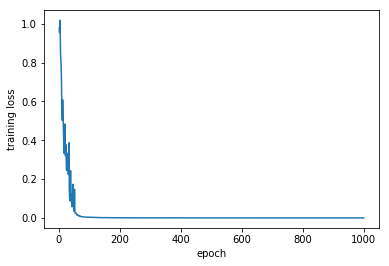

In [66]:
plt.plot(np.arange(num_epochs) + 1, history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()

In [67]:
## Evaluate the network
logits = model(X_test)
    
# Calculate the prediction
pred = tf.argmax(logits, axis=1)
    
# Update the running stats
acc = tf.reduce_mean(tf.cast(pred == y_test, tf.float32)).numpy()
print('Your Test Accuracy is {:.4f}'. format(acc))

Your Test Accuracy is 0.9100


We can again check how confident this Tensorflow model is on the target test review. Like before, this model will be extremely confident in its prediction, regardless of correctness.

In [68]:
bog_target = tf.expand_dims(X_test[target], axis=0)
logits_target = model(bog_target)

pred = tf.argmax(logits_target, axis=1)
probability = tf.exp(tf.squeeze(logits_target)) \
            / tf.reduce_sum(tf.exp(tf.squeeze(logits_target)))

print('Review: ', review_target)
print('Ground Truth: ', label_meaning[int(label_target)])
print('Prediction: %s (Certainty %2.2f%%)' % (label_meaning[int(pred.numpy())], 100.0*probability[int(pred.numpy())]))

Review:  This book expounds endlessly on how best to limit the impact of people on the backcountry in the very best traditions of the Sierra Club.  It's more of a philosophy book than a &quot;how to&quot; book.  If anyone wants to  learn how to backpack and/or camp, he would be better advised to buy the  several books by Karen Berger and Chris Townsend, in particular The  Backpackers Handbook

Ground Truth:  Negative
Prediction: Negative (Certainty 99.94%)
